In [2]:
% load_ext autoreload
% autoreload 2

In [3]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from dataset import MetaDataset
from metadata.vcc import SanityMetadata

from models import save_model, load_model
from models.vae import ToyVAE
from maml import reptile_train

In [3]:
dataset = MetaDataset(SanityMetadata())
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-16 14:19:49.843487


In [4]:
device = torch.device('cpu')
model = ToyVAE()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)


def train(trained_model, x, y, n_inner_loop=8):
    trained_model.train()
    x = torch.transpose(x, 0, 1)
    y = torch.transpose(y, 0, 1)
    x = x.to(device)
    y = y.to(device)
    for _ in range(n_inner_loop):
        optimizer.zero_grad()
        out = trained_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    print(loss.item(), end='')

In [30]:
# Meta train

reptile_train(model, dataset, n_shot=None, n_iter_outer=100,
              outer_step_size=1e-1, inner_train_func=train)
save_model('saved_models/temp.pt', model)

Iter 0: 125.15090942382812
Iter 1: 101.79509735107422
Iter 2: 160.32931518554688
Iter 3: 131.1269989013672
Iter 4: 158.9755401611328
Iter 5: 116.06575775146484
Iter 6: 121.98399353027344
Iter 7: 188.1910858154297
Iter 8: 191.67498779296875
Iter 9: 133.74317932128906
Iter 10: 180.7340087890625
Iter 11: 90.64708709716797
Iter 12: 100.67535400390625
Iter 13: 98.85577392578125
Iter 14: 119.21156311035156
Iter 15: 151.88595581054688
Iter 16: 161.41265869140625
Iter 17: 118.2329330444336
Iter 18: 75.72713470458984
Iter 19: 117.98649597167969
Iter 20: 92.28262329101562
Iter 21: 210.2461395263672
Iter 22: 87.72587585449219
Iter 23: 111.031982421875
Iter 24: 125.01417541503906
Iter 25: 134.67056274414062
Iter 26: 106.5593490600586
Iter 27: 65.36372375488281
Iter 28: 106.77198791503906
Iter 29: 132.02468872070312
Iter 30: 69.64936828613281
Iter 31: 193.44789123535156
Iter 32: 79.97216033935547
Iter 33: 133.81033325195312
Iter 34: 120.16241455078125
Iter 35: 142.34764099121094
Iter 36: 86.4279861

In [22]:
# Second train after meta training

pretrained_model = load_model('saved_models/temp.pt', ToyVAE)


Source train


Target train


Source train aligned


Target train aligned


119.85236358642578

Test source


Test source


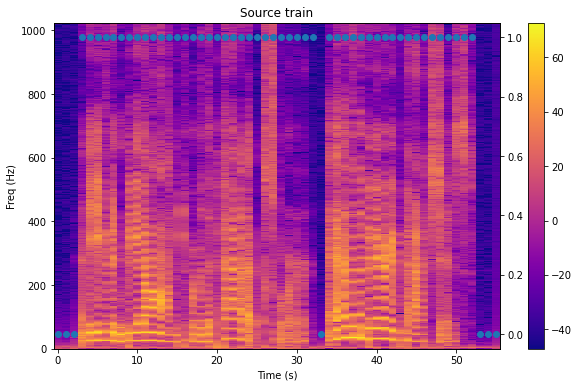

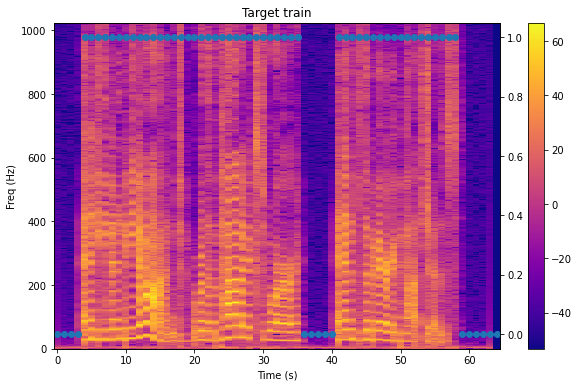

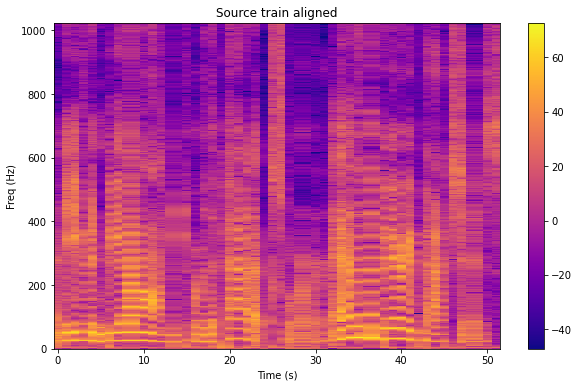

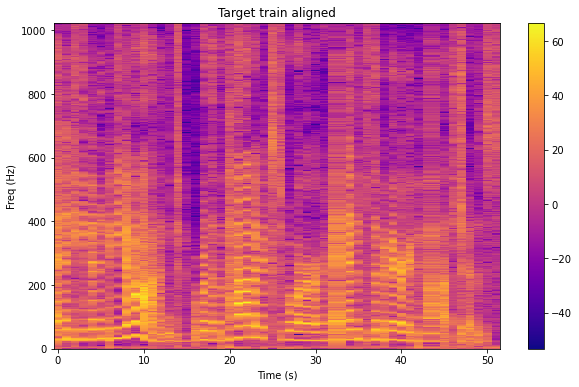

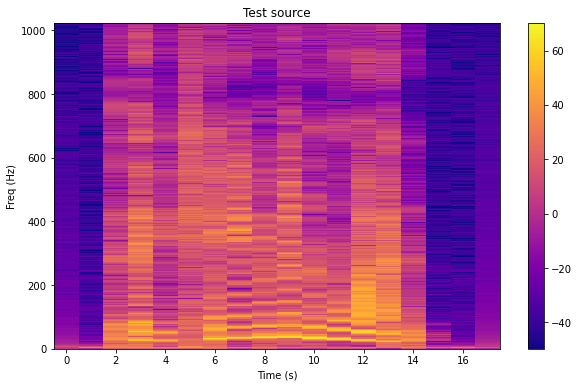

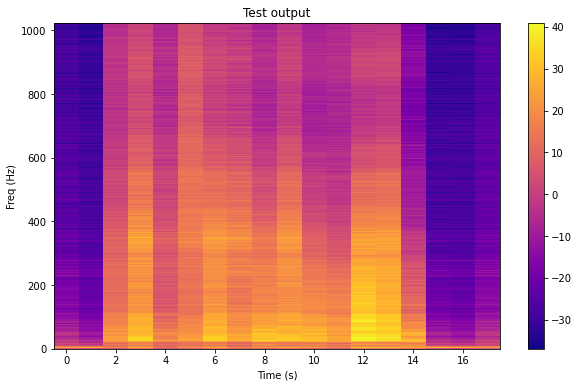

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from env import sr
from transform import log_stft, db_to_amp
from dataset import read_audio, TaskDataset, InputData
from visualization import plot_spec
from vocoder import griffin_lim


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))


def test(model, train_source_filename, train_target_filename,
         test_input_filename):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train')
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train')
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned')
    sound(griffin_lim(db_to_amp(train_x)), label='Source train aligned')

    plot_spec(train_y, title='Target train aligned')
    sound(griffin_lim(db_to_amp(train_y)), label='Target train aligned')

    train_x, train_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
    train(model, train_x, train_y, n_inner_loop=20)

    x = input_dat.get()
    x = torch.from_numpy(x.T)
    estimated = model(x)
    y = estimated.detach().numpy().T
    plot_spec(log_stft(input_dat.dat.amp), title='Test source')
    sound(read_audio(test_input_filename), label='Test source')
    plot_spec(y, title='Test output')
    sound(griffin_lim(db_to_amp(y)), label='Test source')


meta_dat = SanityMetadata()

test(pretrained_model, meta_dat.get(0, 0), meta_dat.get(1, 0),
     meta_dat.get(0, 1))

In [ ]:
# test with actual samples
